# Chapter 3 - Sampling the Imaginary

Standard example: test for vampirism. It correctly detects vampirism 95% of the time, and incorrectly labels mortals as vampires 1% of the time. Of course, vampirism is quite rare, occurring in just 0.1% of the population.

Say someone tests positive for vampirism. What is the probability that they are a vampire?

$$
P(vampire | +) = P(vampire) \frac{P(+|vampire)}{P(+)}
$$

In R:

In [1]:
p_positive_vampire <- 0.95
p_positive_mortal <- 0.01
p_vampire <- 0.001
p_positive <- p_positive_vampire * p_vampire + p_positive_mortal * (1 - p_vampire)
p_vampire_positive <- p_positive_vampire * p_vampire / p_positive
p_vampire_positive

[1] 0.08683729

This is quite counterintuitive! It also has many important implications, because lots of tests have this shape (accurate test but very low incidence).

This was also a challenging calculation. It becomes much easier if we instead talk about counts of people.

The rest of the chapter will be about working with samples.

Let's generate some samples to work with!

In [2]:
GRID_SIZE <- 1000
p_grid <- seq(from=0, to=1, length.out=GRID_SIZE)
prob_p <- rep(1, GRID_SIZE)
prob_data <- dbinom(6, 9, p_grid)
posterior <- prob_p * prob_data
posterior <- posterior / sum(posterior)

Now that we have the posterior, let's sample from it!

In [3]:
samples <- sample(p_grid, prob=posterior, size=1e4, replace=T)

The `sample` function pulls values from a vector, with probabilities given by the `prob` argument.

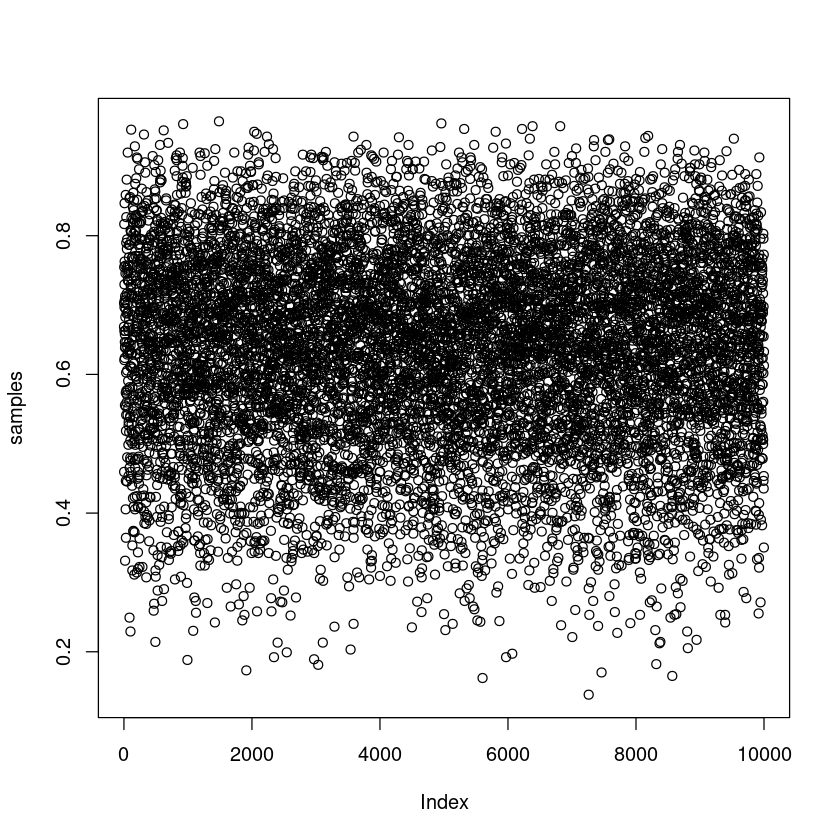

In [4]:
plot(samples)

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Loading required package: cmdstanr

This is cmdstanr version 0.5.0

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- Use set_cmdstan_path() to set the path to CmdStan

- Use install_cmdstan() to install CmdStan

Loading required package: parallel

rethinking (Version 2.21)


Attaching package: ‘rethinking’


The following object is masked from ‘package:rstan’:

    stan


The following object is masked from ‘package:stats’:

    rstudent




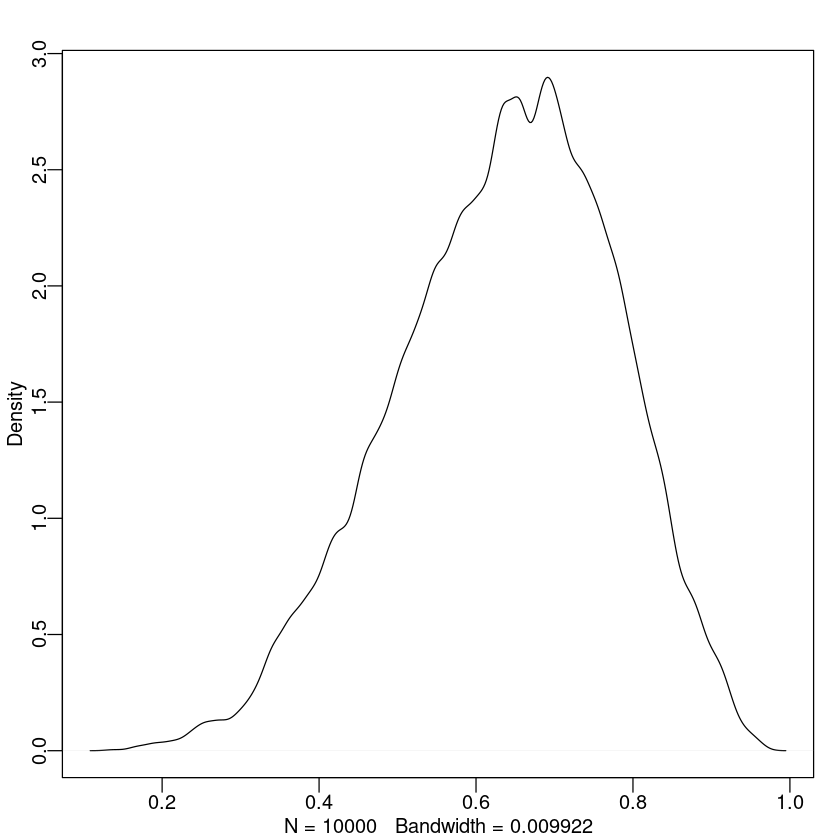

In [5]:
# Same plot, but in a better format (densities)
library(rethinking)
dens(samples)

## Sampling to Summarize

So far we have just created a bad approximation to the result that we already have. Now let's do something useful!

Now that we have the samples, there are some common questions that we might want to answer:
- How much of the posterior probability lies below some value?
- How much of the posterior probability lies between two values?
- Which parameter marks the lower 5% of the distribution?
- Which range of paramter values contains 90% of the posterior probability?
- Which paramter value has the highest posterior probability?

These questions can be divided into a few categories:
1. Intervals of defined boundaries
1. Intervals of defined probability mass
1. Point estimates

### Intervals of Defined Boundaries

Say we want to know for the posterior probability that the proportion of water is less than 0.5. We could just use the posterior:

In [6]:
sum(posterior[p_grid < 0.5])

[1] 0.1718746

But in general it won't be that easy! Let's see how we can do that using the sample instead:

In [7]:
# Recall that we are converting samples < 0.5 to a sequence of T / F, and T -> 1 and F -> 0
sum(samples < 0.5) / 1e4

[1] 0.1749

We can use the same approach to see how much of the posterior probability lies between 0.5 and 0.75:

In [8]:
sum(samples > 0.5 & samples < 0.75) / 1e4

[1] 0.6055

### Intervals of Defined Mass

A confidence interval is one such, and with Bayesian stats the term 'credible interval' is used instead. This book uses 'compatibility interval' instead.

It's actually easier to do this with samples rather than the posterior itself:

In [9]:
# boundary of the lower 80% posterior probability
quantile(samples, 0.8)

80% 
0.7587588

Say we wanted to know where 80% of the mass was. Then we want the boundaries to the 10% quantile and the 90%th:

In [10]:
quantile(samples, c(0.1, 0.9))

10%       90% 
0.4464464 0.8078078

So 80% of the mass is between `p=0.448` and `0.81`.

This sort of interval, which assign equal probability masses to the tails, is very common. We'll call them *percentile intervals*. It is generally good, although it can fail with asymmetrical distributions. For instance, consider the case where we start with a flat prior and see three "Water"s in 3 tosses:

In [11]:
p_grid <- seq(from=0, to=1, length.out=1000)
prior <- rep(1, 1000)
likelihood <- dbinom(3, 3, p_grid)
posterior <- prior * likelihood
posterior <- posterior / sum(posterior)
samples <- sample(p_grid, size=1e4, prob=posterior, replace=T)

PI(samples, prob=0.5)

25%       75% 
0.7027027 0.9329329

So here we have a perfectly respectable interval. However, it doesn't include the most plausible value - $p=1$!

So sometimes we want the Highest Posterior Density Interval (HPDI) - the *narrowest* region which contains the specified mass. Luckily, such a function exists in the `rethinking` library:

In [12]:
HPDI(samples, prob=0.5)

|0.5      0.5| 
0.8408408 1.0000000

In most cases, the PI and the HPDI are very similar. 

Also, it has a few disadvantages.
- More computationally expensive
- More sensitive to `simulation variance` - the actual value depends strongly on how many samples you take
- Harder to understand - some people will misinterpret it

Remember: if the choice of interval you choose makes a big difference, then maybe the intervals are not the best way to represent what you are tying to do anyway.

### Point Estimates

The other thing that we may want to do is to create a point estimate! Mostly this is not a great thing to do - after all, one of the reasons that we do Bayesian statistics is to do things with the entire distrivution, not just a single value.

For example, you might want the single value with the highest probability: the *maximum a priori* (MAP) estimate.

In [13]:
p_grid[which.max(posterior)]

[1] 1

If you just have samples from the distribution:

In [14]:
chainmode(samples, adj=0.1)

[1] 0.9891938

Of course, you might want the mean or median instead:

In [15]:
mean(samples)

[1] 0.7991773

In [16]:
median(samples)

[1] 0.8408408

One way to go beyond using the entire distribution as the estimate is to define a _loss function_.

Say you are offered a bet - tell me the value of $p$, the proportion of water on earth. If you get it exactly right, you get $100. However, depending on how wrong you are, some money will be subtracted from the gain.

The loss is proportional to $d - p$, where $d$ is your decision.

In that case, we should report the median - it minimizes our loss.

If we have the posterior and choose our value $d=0.5$, then the expected loss will be

In [17]:
sum(posterior * abs(0.5 - p_grid))

[1] 0.3128752

In [18]:
# We can do this for all possible values of d
loss <- sapply(p_grid, function(d) {sum(posterior * abs(d - p_grid))})
p_grid[which.min(loss)]

[1] 0.8408408

It turns out that this is exactly the median!

Of course, a different loss function would result in a different point estimate. If we choose the quadratic $(d - p)^2$, then we would get the posterior mean as the best estimate. Of course, the actual function we choose depends on our situation. If we imagine providing a point estimate of wind speed when trying to determine whether or not to order an evacuation, the loss function will depend on the cost of doing so, the estimated damage, &c.

## Sampling to Simulate Prediction

Another job for samples is to ease simulation of the model's implied observations.

1. Model design: We can sample not only from the posterior, but from the prior as well. Seeing what the model predicts before the data arrives is a good way to understand the implications of the prior.
1. Model checking: After a model is updated using data, it is worth simulating implied observations to check both thether the fit worked correctly and to investigate model behaviour
1. Software validation: In order to check that our software actually works, it can be good to generate some data with known characteristics and then be sure that we can recover those
1. Research design: If you can simulate observations, then you can evaluate whether the research design is effective. This is kind of like doing a power analysis, but the possibilities are much broader
1. Forecasting: Estimates can be used to simulate new predictions, for new cases and future observation.

### Dummy data

Globe tossing example: proportion $p$ of water, $1 - p$ of land. Then we can simulate some dummy data with the following observed counts of $W$ Water in $N$ tosses:

$$
P(W|N) = \binom{N}{W} p^W (1 - p)^{N - W}
$$

Then we can calculate the probability of seeing different counts given a true probability of the proportion of water:

In [19]:
dummy <- dbinom(0:2, size=2, prob=0.7)
dummy

[1] 0.09 0.42 0.49

(So there is a 9% chance of a single experiment resulting in 0 waters, 42% of seeing exactly one, and 49% chance of seeing two)

Now we want to sample from this. Luckily, there are sampling functions built in for most of the standard distributions:

In [20]:
# here we generate a single sample. The result is the number of waters observed in the two draws
dummy_samples <- rbinom(1, size=2, prob=0.7)
dummy_samples

[1] 2

In [21]:
# multiple samples:
rbinom(10, 2, 0.7)

[1] 2 2 0 1 2 2 1 1 2 1

In [22]:
# let's generate lots of samples to verify our probability calculations:
dummy_w <- rbinom(1e5, 2, 0.7)
table(dummy_w) / 1e5

dummy_w
      0       1       2 
0.09160 0.41955 0.48885 

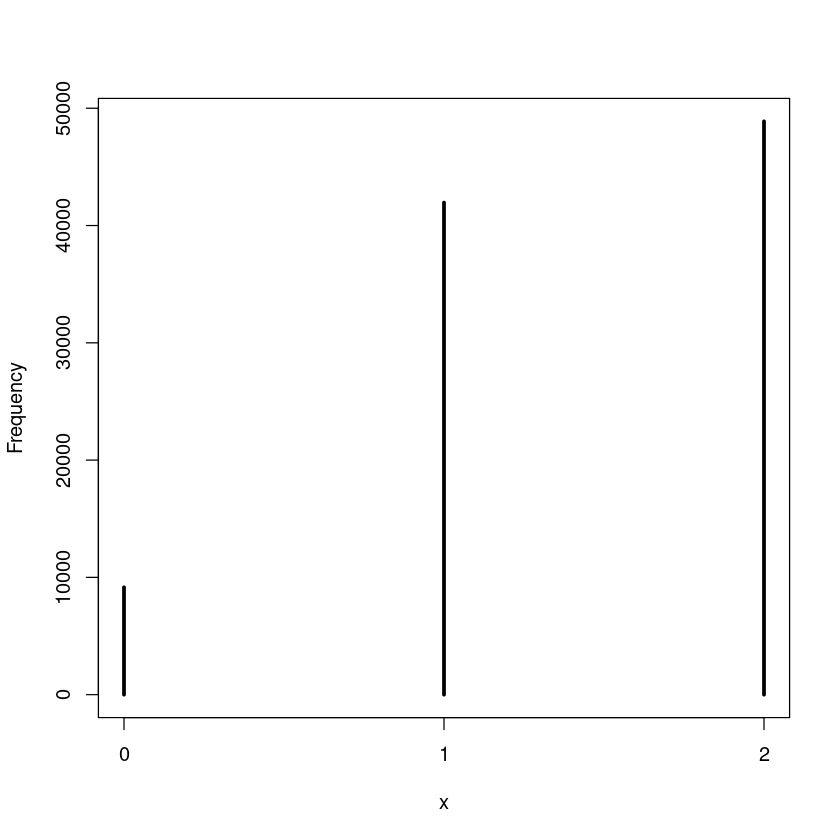

In [23]:
simplehist(dummy_w)

In [24]:
# Now let's try it with 9 tossed
dummy_w <- rbinom(1e5, 9, 0.7)
tabulated <- table(dummy_w) / 1e5
tabulated

dummy_w
      0       1       2       3       4       5       6       7       8       9 
0.00002 0.00032 0.00393 0.02074 0.07478 0.17141 0.26652 0.26586 0.15656 0.03986 

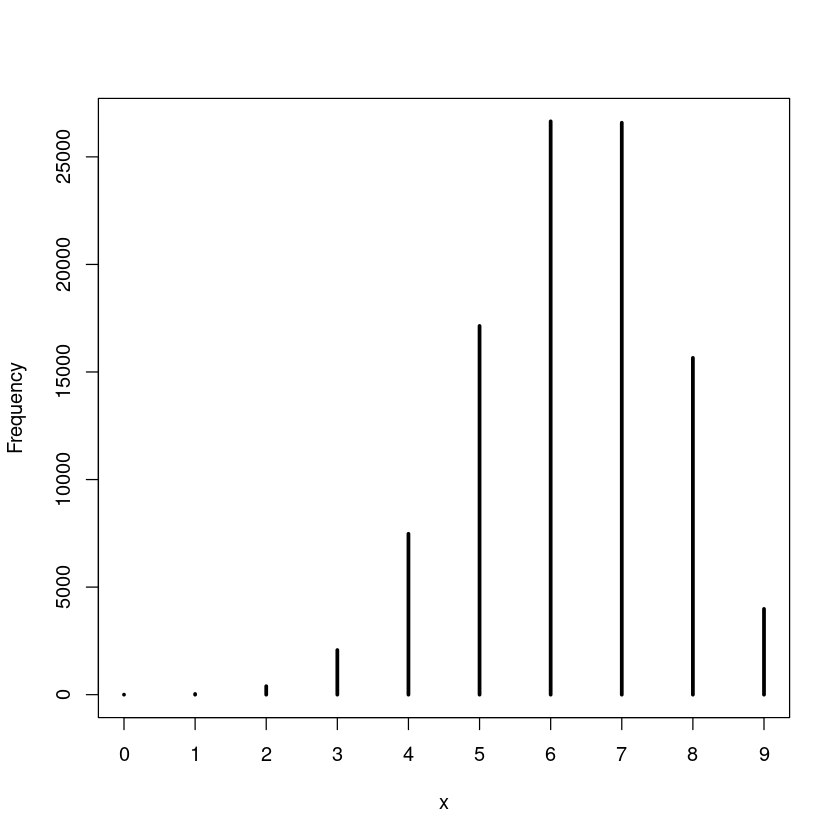

In [25]:
simplehist(dummy_w)

### Model Checking

This has two meanings:
1. Ensuring that the model fitting worked correctly, and
1. Evaluating the suitability of the model for some purpose

Since Bayesian models are always generative (able to simulate observations as well as estimate parameters from observations), we can always run some simulations to see what kinds of predictions that model produces.

Another thing: we can check whether the software even worked! For instance, we generally expect that if we generate the data using some parameters, we should be able to at least approximately recover those parameters from the generated data.

Once we are pretty sure that the software works, we can check in what way the model fails to describe the data.

"Posterior predictive distribution": in our case, we have some uncertainty about the value of $p$ - we have a distribution, not a value. For each value, there is also some uncertainty: even if we knew $p$ exactly, we would get different numbers of observations of number of $W$. Our posterior predictive distribution is the distribution of observed $W$, taking into account both of those areas of uncertainty.

So, how do we do this?

In [26]:
# one value of p
w <- rbinom(1e4, 9, prob=0.6)

# different values of p!
w <- rbinom(1e4, 9, samples)
w

[1] 9 0 9 8 9 7 5 7 9 3 7 6 9 9 9 8 6 4 9 9 2 6 7 7 9 6 8 5 6 3 8 6 3 9 8 9
   [37] 9 8 8 6 6 9 8 9 9 9 8 9 8 9 9 8 9 9 8 4 6 7 9 2 9 7 9 9 9 9 9 5 8 8 9 7
   [73] 4 8 9 9 6 6 7 8 7 9 7 7 9 3 6 9 9 8 9 8 7 9 9 2 6 8 8 8 3 5 4 8 3 9 9 7
  [109] 8 7 5 9 7 4 8 9 8 8 7 7 7 4 9 9 7 7 9 4 7 9 2 6 8 5 8 6 9 8 4 8 8 8 6 9
  [145] 4 9 8 7 9 8 9 5 7 7 9 8 8 9 6 7 9 8 7 9 9 8 6 6 7 9 5 7 6 7 9 4 2 6 7 8
  [181] 8 8 9 8 7 6 7 6 5 8 6 8 9 9 8 9 8 9 5 6 8 4 6 6 9 5 8 6 9 9 9 6 4 3 9 5
  [217] 7 8 6 7 7 7 8 8 9 8 9 8 5 8 9 9 9 2 5 7 7 3 4 8 6 9 7 8 4 9 8 8 9 7 9 5
  [253] 7 8 9 8 8 4 4 5 7 8 9 6 6 9 9 6 4 9 8 9 8 5 9 5 9 7 5 1 9 8 5 6 7 8 9 4
  [289] 9 9 9 9 8 7 8 9 9 9 1 8 5 7 7 6 9 8 8 6 8 9 9 7 9 7 9 8 7 6 8 3 8 6 1 9
  [325] 8 8 8 6 7 9 8 9 8 7 5 6 9 9 5 4 4 5 9 7 9 6 6 4 6 9 7 9 4 9 9 9 7 9 9 8
  [361] 8 5 4 6 5 8 6 9 9 6 8 9 7 7 8 9 5 4 6 9 8 3 9 8 9 8 8 7 9 7 9 8 9 8 8 7
  [397] 4 9 8 9 9 9 9 9 5 6 8 6 7 3 2 5 9 8 4 9 9 8 7 9 6 4 6 9 9 8 7 6 9 4 7 7
  [433] 7 2 9 9 7 9 4 9 6 7 7 3 8 5 8 7 6 2 9 8 3 3 8 9 9 2 8 6 5 6 9 8 4 5 9 9
  [469] 4 8 9 9 8 6 8 9 2 5 4 7 8 8 7 9 8 7 9 8 8 9 5 4 4 8 6 5 8 6 9 9 8 9 2 6
  [505] 9 9 8 8 9 4 6 7 8 9 7 9 8 9 8 8 6 9 8 5 8 7 9 5 8 9 5 8 7 9 7 8 7 9 8 8
  [541] 6 8 9 8 7 4 8 5 5 9 6 9 7 6 9 8 8 5 9 8 7 6 9 6 7 9 7 8 5 9 8 9 9 8 8 9
  [577] 6 9 9 8 7 6 9 5 8 7 9 9 7 9 5 8 5 8 6 6 3 9 9 8 9 8 8 9 5 9 5 7 9 9 4 7
  [613] 8 7 7 8 6 4 9 2 9 5 4 9 8 9 3 8 5 7 5 8 5 6 9 9 6 6 9 3 9 7 9 8 8 9 8 9
  [649] 8 8 8 4 9 7 9 8 8 8 8 8 5 5 9 9 9 7 8 9 9 8 8 6 9 9 8 7 7 8 6 4 3 7 9 7
  [685] 7 8 8 8 7 6 8 5 9 6 7 4 2 9 7 9 7 8 7 9 6 9 8 9 7 7 8 9 9 7 9 9 9 3 8 9
  [721] 7 6 8 6 6 8 8 5 3 8 9 7 8 8 8 8 9 9 9 6 7 9 9 5 5 7 2 8 9 9 7 8 7 7 9 5
  [757] 4 7 7 9 7 8 9 4 7 8 6 7 9 6 6 9 6 4 4 9 9 8 9 5 4 8 6 8 8 8 7 5 8 9 2 5
  [793] 1 7 6 8 6 7 4 4 9 9 7 7 9 9 7 9 9 9 8 6 5 9 9 8 9 6 8 4 8 9 9 9 7 8 6 7
  [829] 9 8 6 9 6 9 9 8 4 9 7 5 8 9 8 9 7 8 9 9 9 9 5 9 8 3 9 9 9 8 2 8 9 7 6 0
  [865] 7 9 3 6 1 5 8 9 7 7 1 6 8 6 9 1 8 9 7 9 6 7 9 3 7 8 9 8 8 9 9 5 9 9 8 8
  [901] 6 5 9 8 6 3 6 8 8 5 6 5 8 7 9 7 5 7 7 8 7 8 9 8 5 8 8 7 4 9 8 6 5 7 5 8
  [937] 7 9 9 8 5 8 7 7 9 4 8 7 9 9 7 8 8 9 3 7 9 9 9 9 9 8 3 9 9 9 9 6 6 9 6 8
  [973] 8 8 7 6 9 7 8 6 8 8 6 1 5 5 9 8 7 9 9 3 9 7 8 6 7 7 7 8 6 3 9 6 4 8 4 6
 [1009] 6 6 9 6 9 8 5 5 9 8 9 4 9 7 4 4 6 6 7 1 8 9 7 5 9 9 8 9 5 9 9 9 7 4 8 3
 [1045] 8 8 9 0 5 7 7 9 8 9 8 7 6 6 9 4 6 4 6 7 8 9 6 9 9 8 9 9 9 7 7 8 9 6 9 4
 [1081] 7 7 8 5 7 8 8 1 6 8 8 9 9 9 8 7 6 9 8 8 9 4 8 5 3 9 8 6 7 9 7 7 8 8 9 8
 [1117] 6 9 6 8 8 9 6 8 8 9 9 8 8 2 7 8 9 9 5 8 9 8 7 9 5 4 6 8 8 7 6 7 7 6 9 7
 [1153] 9 4 4 5 7 9 9 3 5 8 9 8 4 9 7 6 6 9 9 8 6 9 8 7 8 8 7 8 8 9 4 8 8 5 7 9
 [1189] 9 8 7 6 8 9 9 9 7 6 5 7 5 3 9 7 9 4 9 6 7 9 9 8 9 9 7 8 9 8 9 7 9 7 7 6
 [1225] 8 9 7 9 2 6 7 5 4 7 9 6 5 6 9 4 9 8 8 8 8 6 8 9 9 8 9 7 6 4 9 9 3 5 8 7
 [1261] 9 3 9 7 9 4 8 9 7 7 9 3 9 9 5 9 9 8 8 6 9 2 8 8 9 9 9 7 6 9 9 9 5 2 3 9
 [1297] 7 8 8 8 8 5 8 7 9 8 9 6 7 8 9 7 6 4 8 7 9 8 6 8 6 8 8 6 8 9 4 7 7 9 9 7
 [1333] 6 6 8 8 9 9 7 9 6 9 8 3 9 3 8 2 5 9 7 7 3 5 7 4 8 6 3 8 9 3 9 9 7 8 8 7
 [1369] 9 9 8 9 7 9 9 8 7 9 7 8 9 8 8 8 4 7 9 8 4 9 8 6 8 9 7 8 6 9 7 9 7 9 8 8
 [1405] 6 9 7 9 9 5 9 7 5 9 6 9 9 8 8 9 6 7 4 9 9 7 9 6 9 9 6 8 7 8 2 7 1 8 9 8
 [1441] 5 5 7 6 9 6 7 8 6 8 8 8 4 5 6 9 7 9 9 8 7 7 4 9 8 7 7 9 9 7 9 7 7 9 9 5
 [1477] 8 6 8 8 9 8 9 8 9 7 9 6 8 9 9 6 9 5 8 8 9 7 8 6 9 9 9 8 8 4 8 5 8 7 8 6
 [1513] 8 8 6 9 5 7 8 7 5 7 9 8 6 1 9 7 9 8 8 7 8 9 8 8 9 7 9 8 8 8 7 9 6 8 9 9
 [1549] 6 8 9 9 3 8 9 4 9 6 8 8 7 7 6 7 6 9 8 8 9 9 5 7 8 9 5 8 5 9 9 7 6 9 7 9
 [1585] 8 6 6 4 9 9 8 9 8 5 4 7 9 6 7 7 8 9 8 4 9 9 9 6 8 9 8 8 8 6 7 9 9 9 5 9
 [1621] 9 6 9 3 7 7 9 9 6 8 5 8 9 9 7 5 9 4 6 3 7 4 6 8 9 9 5 7 4 6 8 8 8 2 9 8
 [1657] 9 9 9 9 6 9 7 8 8 5 3 7 8 5 9 5 7 9 7 9 6 8 1 5 3 8 9 7 8 9 4 4 9 8 7 8
 [1693] 1 1 6 8 7 4 9 8 6 6 6 6 7 6 6 9 7 7 6 7 5 7 8 8 9 9 9 7 2 8 8 5 6 2 9 8
 [1729] 8 6 7 9 9 8 9 9 7 9 9 9 9 8 6 8 5 6 8 9 9 3 6 8 7 9 8 6 8 8 8 7 8 9 8 7
 [1765] 8 5 9 9 8 5 9 7 3 8 9 7 7 9 7 7 3 8 6 6 9 9 6 9 8 9 9 5 8 8 8 3 4 9 9 6
 [18

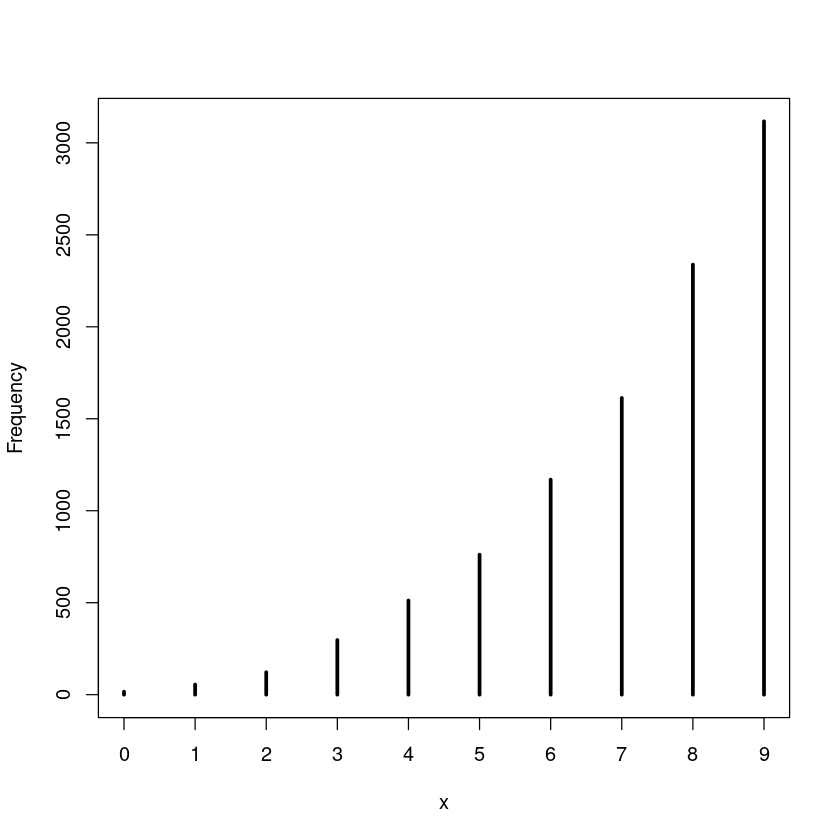

In [27]:
simplehist(w)

Of course, we also assumed that each toss was independent, but it is easy to see how that could fail. Apart from the bias of the person tossing, water and land are not uniformly distributed - if one toss lands on the Pacific Ocean, then that might make it more likely to land on it again in the subsequent toss (maybe the tosser doesn't put enough spin on the globe or something).

## Practice

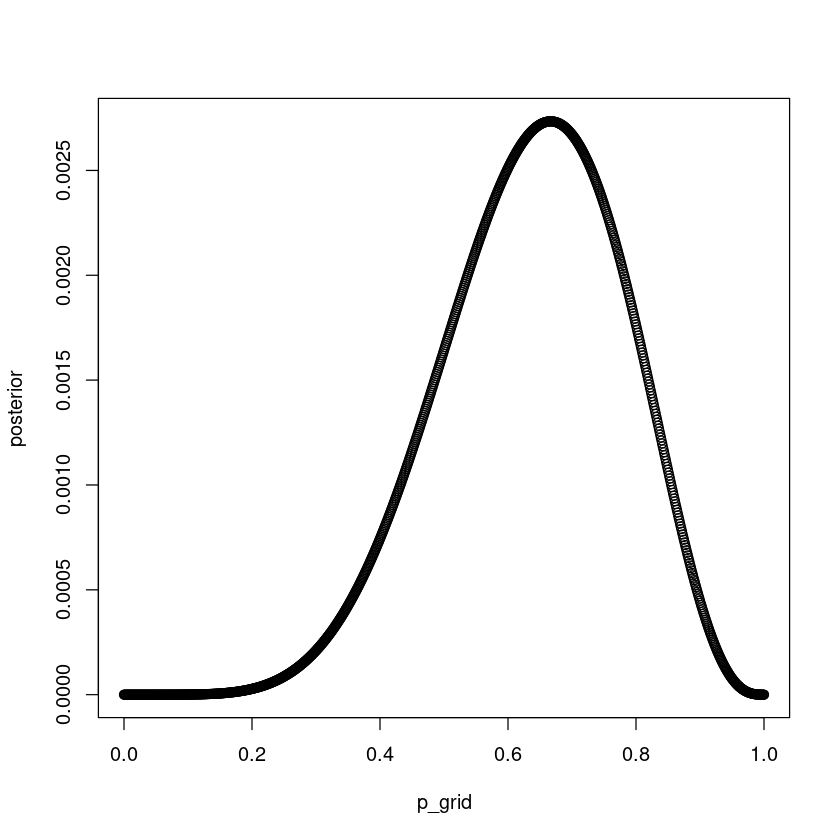

In [28]:
# Exact values to use for the E exercises
p_grid <- seq(from=0, to=1, length.out=1000)
prior <- rep(1, 1000)
likelihood <- dbinom(6, 9, p_grid)
posterior <- likelihood * prior
posterior <- posterior / sum(posterior)
plot(p_grid, posterior)

set.seed(100)
size <- 1e4
samples <- sample(p_grid, prob=posterior, size=size, replace=T)

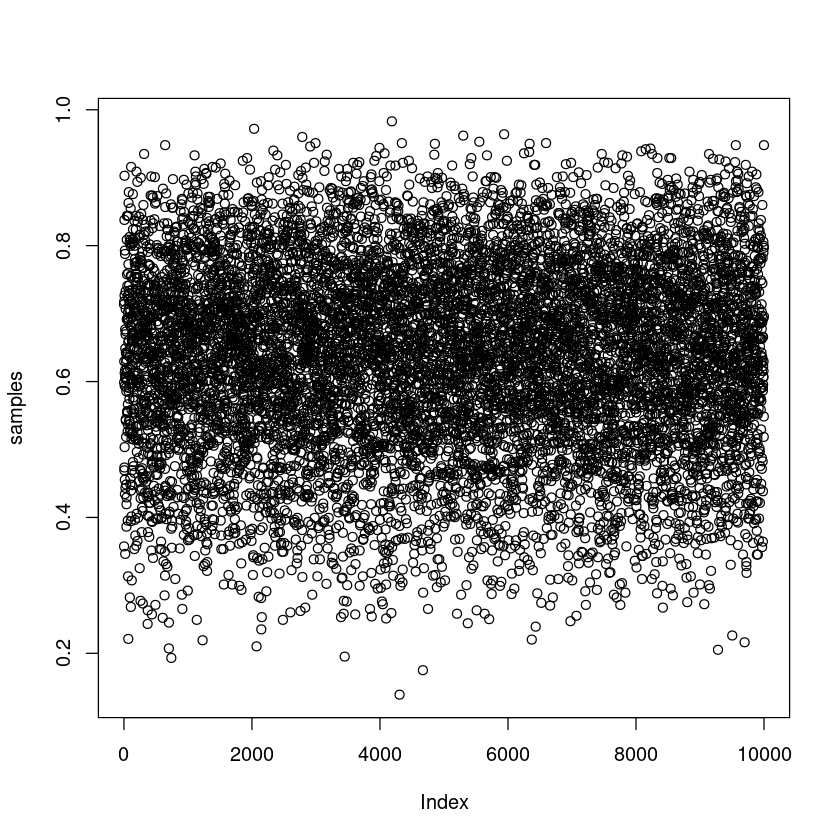

In [29]:
plot(samples)

In [30]:
# 3E1 - How much posterior probability lies below p=0.2?
sum(samples < 0.2) / size

[1] 4e-04

In [31]:
# 3E2 - how much above 0.8?
sum(samples > 0.8) / size

[1] 0.1116

In [32]:
# 3E3 - how much between 0.2 and 0.8
sum(samples > 0.2 & samples < 0.8) / size

[1] 0.888

In [33]:
# 3E4 20% of the posterior lies below which value of p?
quantile(samples, 0.2)

20% 
0.5185185

In [34]:
# 3E5 20% lies above which?
quantile(samples, 0.8)

80% 
0.7557558

In [35]:
# 3E6 Which values of p contain the narrowest interval equal to 66% of the posterior?
HPDI(samples, 0.66)

|0.66     0.66| 
0.5085085 0.7737738

In [36]:
# 3E7 Which interval contains 66% of the posterior, assuming equal amounts in the left and right tails?
PI(samples, 0.66)

17%       83% 
0.5025025 0.7697698

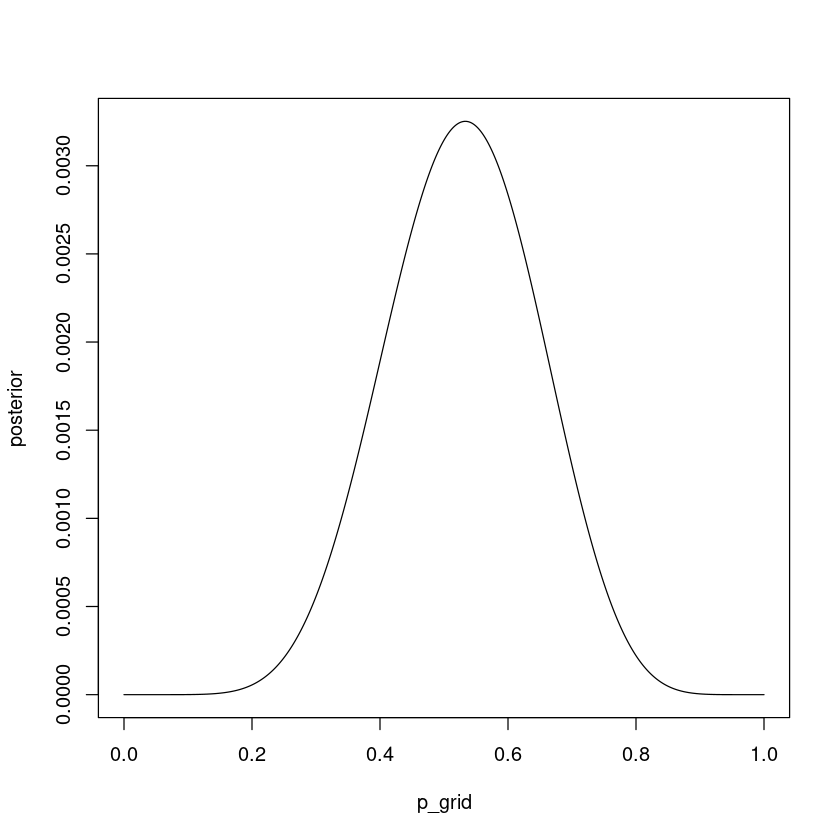

In [37]:
# 3M1 - Suppose the globe tossing had been 8 W in 15 tosses. Construct a new grid posterior.
p_grid <- seq(from=0, to=1, length.out=1000)
prior <- rep(1, length(p_grid))
likelihood <- dbinom(8, 15, p_grid)
posterior <- prior * likelihood
posterior <- posterior / sum(posterior)
plot(p_grid, posterior, type="l")
m1_posterior <- posterior

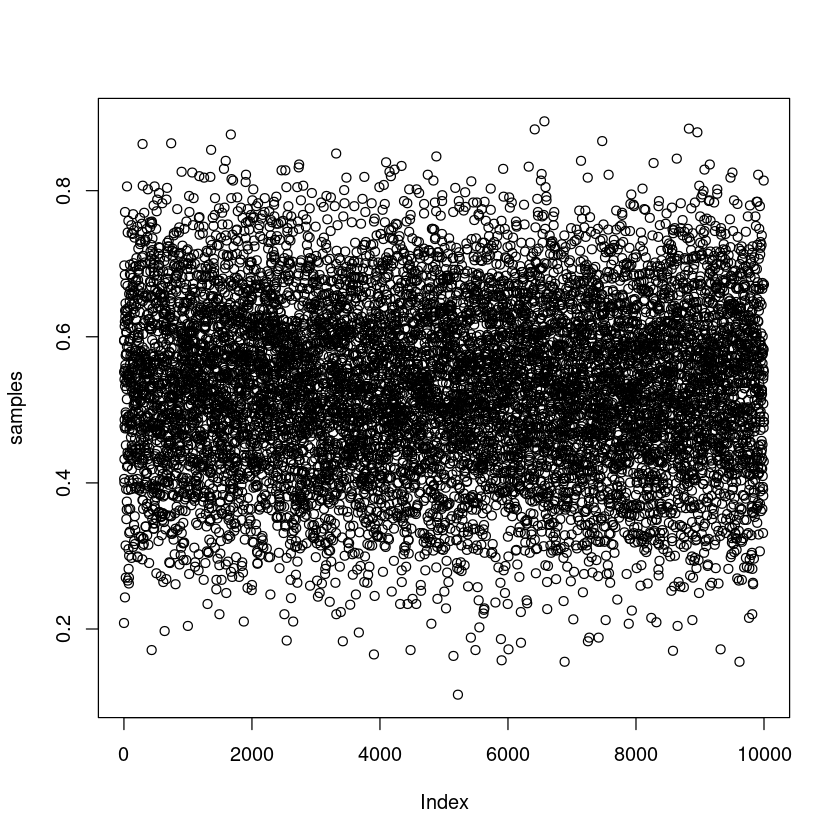

In [38]:
# 3M2 - Draw 10 000 samples from the prior calculated above. Then use the sampkes to calculate the 90% HPDI for p
samples <- sample(p_grid, size=10000, prob=posterior, replace=T)
plot(samples)

In [46]:
m2_hpdi = HPDI(samples, 0.9)
m2_hpdi

|0.9      0.9| 
0.3293293 0.7167167

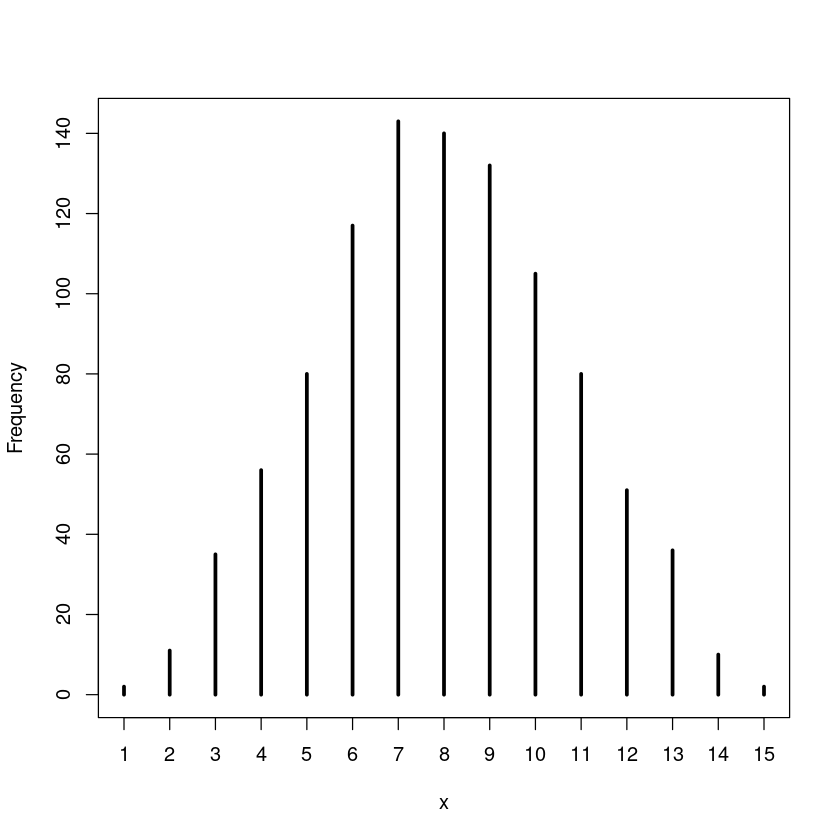

In [40]:
# 3M3 - Construct a posterior predictive check for this model and data. This means simulate the
# distribution of samples, averaging over the posterior uncertainty in p. What is the probability
# of observing the 8 waters in 15 tosses?
pp <- rbinom(1000, 15, prob=samples)
simplehist(pp)

In [41]:
sum(pp == 8) / length(pp)

[1] 0.14

In [42]:
# 3M4 - Using the posterior constructed from the 8 / 15 data,
# calculate the probability of observing 6 water in 9 tossed

results_probs = dbinom(6, 9, p_grid)
total_prob = sum(posterior * results_probs)
total_prob

[1] 0.1763898

In [43]:
# an alternate solution (found in the solutions manual): just create random samples of 6 / 9, with probabilities
# drawn from the samples
w <- rbinom(1000, 9, prob=samples)
sum(w == 6) / length(w)

[1] 0.184

In [44]:
# 3M5 - Start over at 3M1, but now use a prior which is 0 below p=0.5 and a constant above it
# (representing the fact that we know that majority of the earth's surface is water)
# How does that change the results?

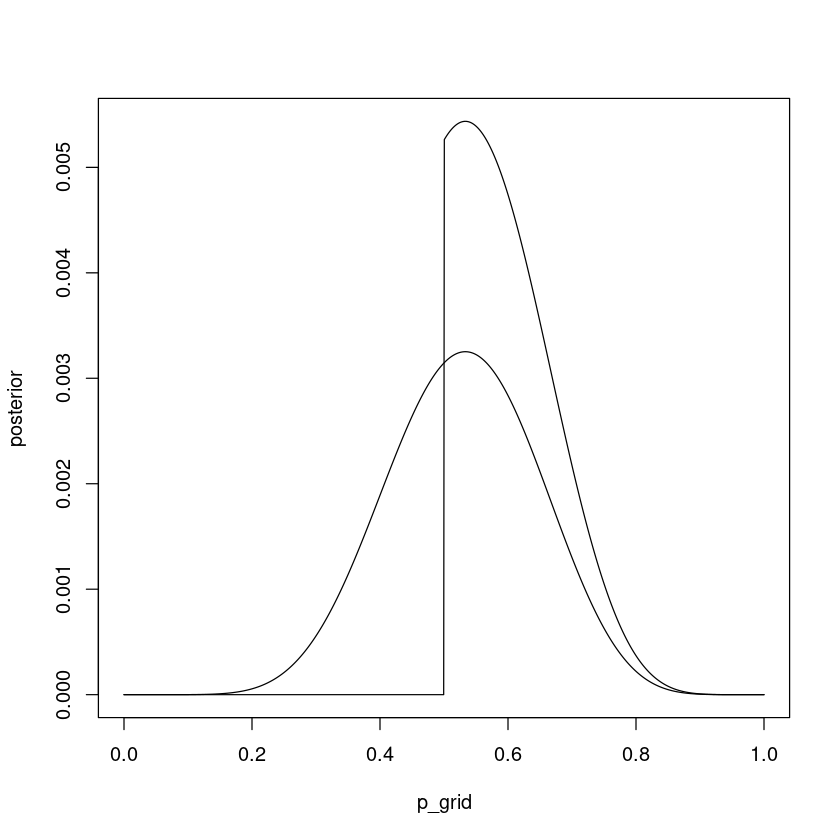

In [45]:
# 3M5 - 3M1
p_grid <- p_grid # this is the same
prior <- p_grid > 0.5
likelihood <- dbinom(8, 15, p_grid)
posterior <- prior * likelihood
posterior <- posterior / sum(posterior)
plot(p_grid, posterior, type='l')
lines(p_grid, m1_posterior, type='l')

In [50]:
# 3M5 - 3M2
samples = sample(p_grid, 1e5, replace=T, prob=posterior)
hpdi = HPDI(samples, 0.9)
hpdi

|0.9      0.9| 
0.5005005 0.7117117

In [51]:
m2_hpdi

|0.9      0.9| 
0.3293293 0.7167167

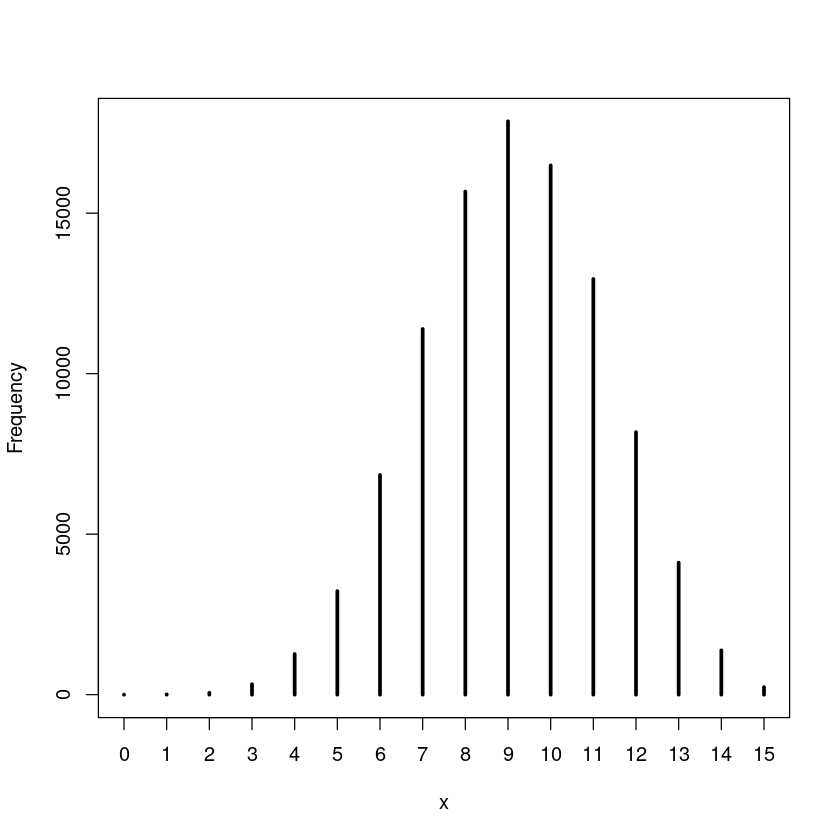

In [52]:
# 3M5 - 3M3
pp <- rbinom(1e5, 15, prob=samples)
simplehist(pp)

In [53]:
sum(pp == 8) / length(pp)

[1] 0.15674

In [81]:
# 3M6 - Say that we want the estimate to be very precise. Specifically, we want the 99% credible interval to be only 0.05 wide.
# How many times do we have to sample the data?

hpdi = c(0, 1)
p = 0.7
posterior = rep(1, length(p_grid))
num_samples = 0
while (hpdi[2] - hpdi[1] > 0.05) {
    num_samples <- num_samples + 1
    prior = posterior
    sample <- rbinom(1, 1, p)
    likelihood = dbinom(sample, 1, p_grid)
    posterior = prior * likelihood
    posterior <- posterior / sum(posterior)
    samples <- sample(p_grid, 1e5, replace=T, prob=posterior)
    hpdi = HPDI(samples, 0.99)
}
num_samples
hpdi

[1] 2104

|0.99     0.99| 
0.6696697 0.7187187

In [85]:
# Hard Problems - they use the data to indicate the gender of a child. 1 is male, 0 is female. load the data from the library.
data(homeworkch3)

In [94]:
birth1
birth2
num_boys <- sum(birth1) + sum(birth2)
total_births <- length(birth1) + length(birth2)
num_boys
total_births

[1] 1 0 0 0 1 1 0 1 0 1 0 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 1
 [38] 1 0 1 0 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1 1
 [75] 1 0 1 0 1 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1

[1] 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 0
 [38] 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 0 0
 [75] 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 1 0 0 0 0

[1] 111

[1] 200

In [90]:
# 3H1
prior <- rep(1, length(num_boys))
likelihood <- dbinom(num_boys, total_births, p_grid)
posterior <- prior * likelihood
posterior <- posterior / sum(posterior)

In [92]:
p_grid[which.max(posterior)]

[1] 0.5545546

In [99]:
# 3H2 - Draw 10 000 random samples from the posterior, and calculate the 50%, 89%, and 97% credible intervals
samples <- sample(p_grid, 1e5, replace=T, prob=posterior)
HPDI(samples, 0.5)
HPDI(samples, 0.89)
HPDI(samples, 0.97)

|0.5      0.5| 
0.5255255 0.5725726

|0.89     0.89| 
0.4964965 0.6076076

|0.97     0.97| 
0.4774775 0.6276276

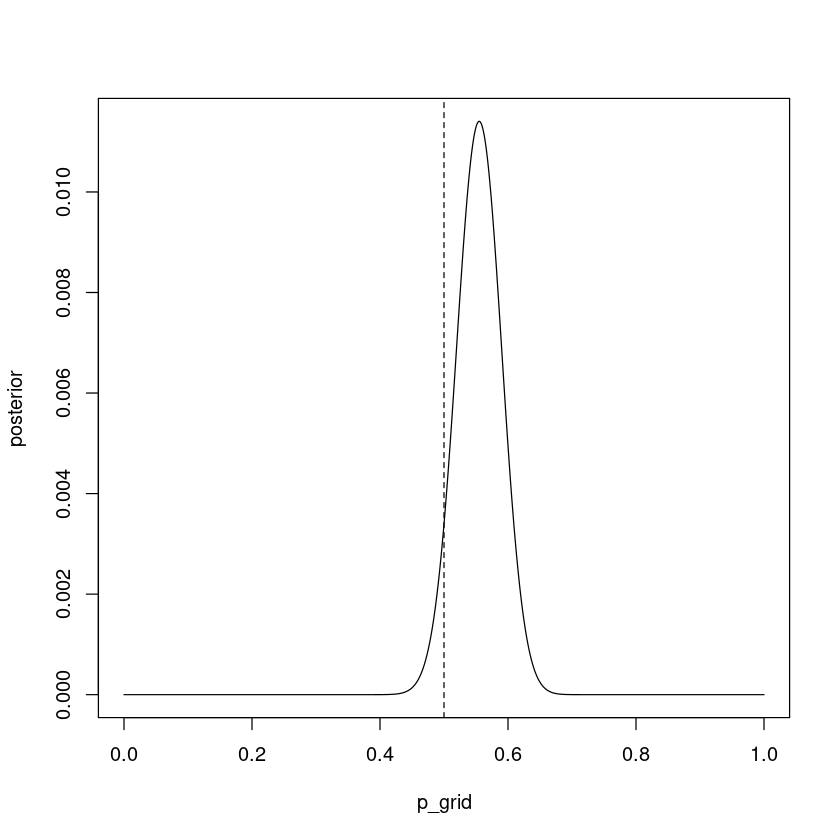

In [98]:
plot(posterior ~ p_grid, type="l")
abline(v=0.5, lty=2)

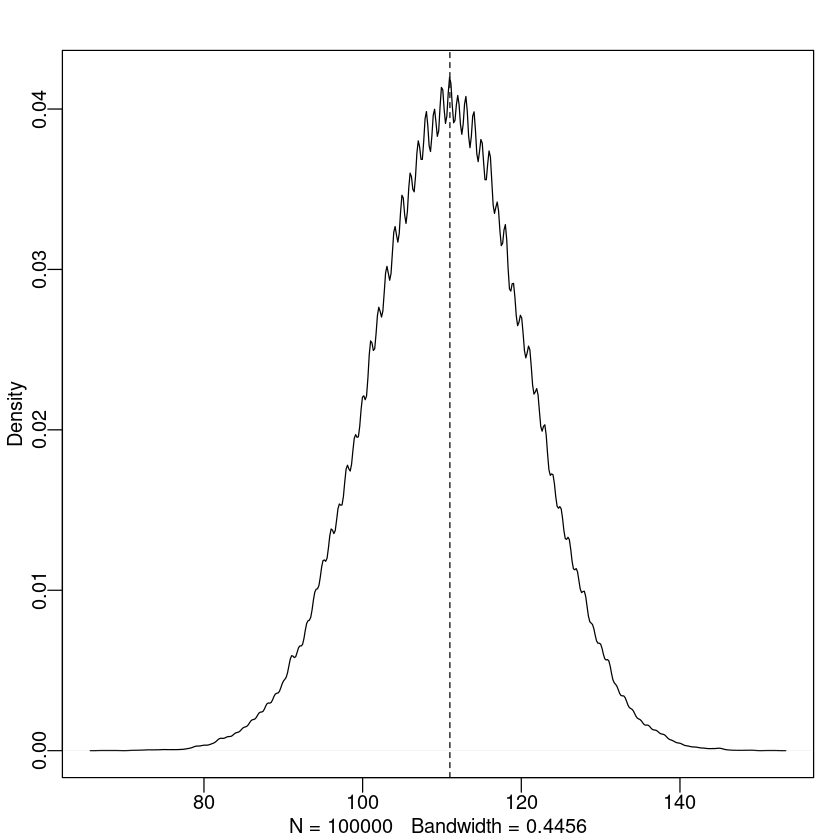

In [105]:
# 3H3 - Use `rbinom` to simulate 10 000 replicates of 200 births. You should end up with 10 000 numbers, each of which is the number of boys
# out of 200 births. Compare the distribution of the number of births to the observed number of births.
# Probably dens (from the rethinking library) is the best way.
sample_boy_nums <- rbinom(1e5, 200, prob=samples)
dens(sample_boy_nums)
abline(v=num_boys, lty=2)

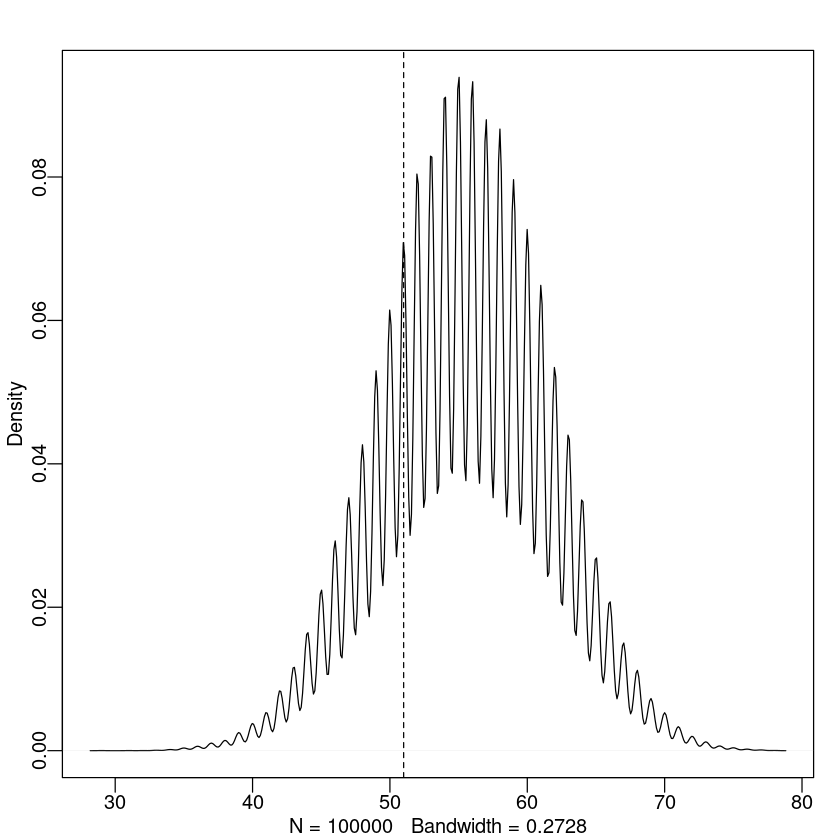

In [108]:
# 3H4 - Now compare 10 000 counts of boys from 100 first borns only to the number in the first births, birth1. How does the model look in this light?
firstborn_samples <- rbinom(1e5, 100, prob=samples)
dens(firstborn_samples)
abline(v=sum(birth1), lty=2)

So this doesn't look as good - we are way off of the centre!

In [110]:
# 3H5 - The model assumes that the sex of the first and second children are independent. Let's test this by focussing only on second births that
# followed female first births. Compare 10 000 simulated counts of boys to only those whose second births that followed girls. To do this
# correctly, you need to count the number of boys that followed girls and the number of girls that followed girls. 
# How does the model do in this light? Any guesses as to what is going on here?
num_first_girls = sum(birth1 == 0)
num_first_girls

[1] 49

In [111]:
num_boys_following_girl = sum(birth1 == 0 & birth2 == 1)
num_boys_following_girl

[1] 39

In [113]:
boys_following_girls_samples <- rbinom(1e5, 49, prob=samples)

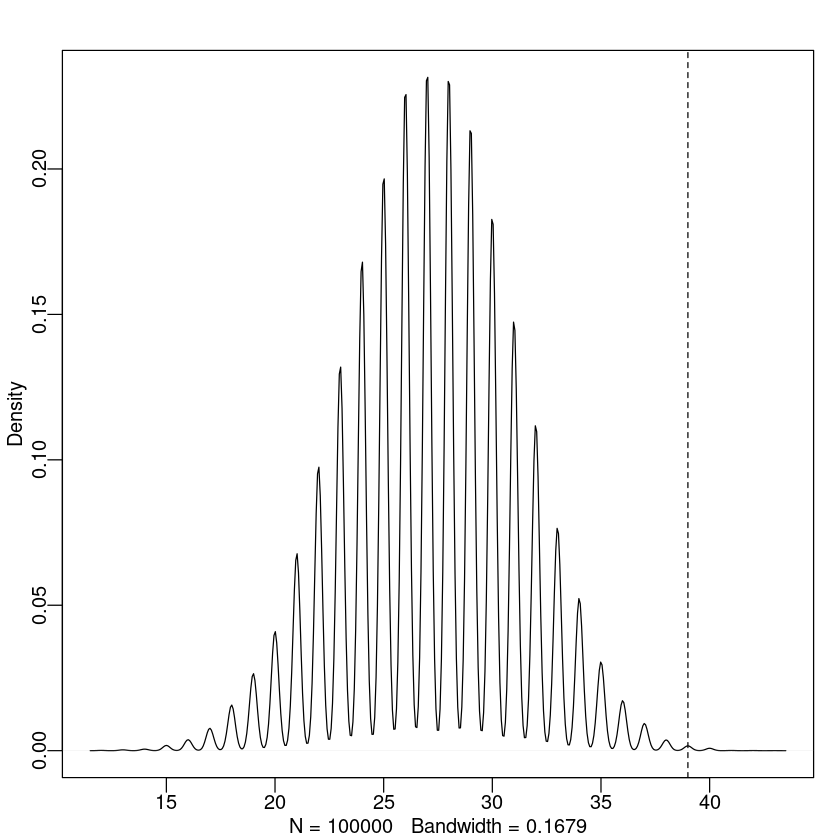

In [114]:
dens(boys_following_girls_samples)
abline(v=39, lty=2)

Hmmm... so we seem to have way more boys that follow girls than we would expect.